## 1. Import


In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')


## 2. 평가 함수 정의 (NMAE 집중)


In [ ]:
def comovement_nmae(answer_df, submission_df, eps=1e-6):
    """
    전체 U = G ∪ P에 대한 clipped NMAE 계산
    NMAE가 낮을수록 좋음 (0에 가까울수록 좋음)
    """
    ans = answer_df[["leading_item_id", "following_item_id", "value"]].copy()
    sub = submission_df[["leading_item_id", "following_item_id", "value"]].copy()
    ans["pair"] = list(zip(ans["leading_item_id"], ans["following_item_id"]))
    sub["pair"] = list(zip(sub["leading_item_id"], sub["following_item_id"]))
    
    G = set(ans["pair"])
    P = set(sub["pair"])
    U = G | P
    
    ans_val = dict(zip(ans["pair"], ans["value"]))
    sub_val = dict(zip(sub["pair"], sub["value"]))
    
    errors = []
    for pair in U:
        if pair in G and pair in P:
            # 정수 변환(반올림)
            y_true = int(round(float(ans_val[pair])))
            y_pred = int(round(float(sub_val[pair])))
            rel_err = abs(y_true - y_pred) / (abs(y_true) + eps)
            rel_err = min(rel_err, 1.0)  # 오차 100% 이상은 100%로 간주
        else:
            rel_err = 1.0  # FN, FP는 오차 100%
        errors.append(rel_err)
    
    return np.mean(errors) if errors else 1.0


## 3. 데이터 전처리 및 학습/검증 분리


In [ ]:
train = pd.read_csv('../data/raw/train.csv')

# year, month, item_id 기준으로 value 합산
monthly = (
    train
    .groupby(["item_id", "year", "month"], as_index=False)["value"]
    .sum()
)

# year, month를 하나의 키(ym)로 묶기
monthly["ym"] = pd.to_datetime(
    monthly["year"].astype(str) + "-" + monthly["month"].astype(str).str.zfill(2)
)

# item_id × ym 피벗 (월별 총 무역량 매트릭스 생성)
pivot = (
    monthly
    .pivot(index="item_id", columns="ym", values="value")
    .fillna(0.0)
)

# 2025-07-01을 기준으로 학습/검증 분리
val_date = pd.to_datetime("2025-07-01")

# 학습 데이터: 2025-07-01 이전 데이터만 사용
pivot_train = pivot.loc[:, pivot.columns < val_date].copy()
print(f"학습 데이터 기간: {pivot_train.columns.min()} ~ {pivot_train.columns.max()}")
print(f"학습 데이터 shape: {pivot_train.shape}")

# 검증 데이터: 2025-07-01 데이터
if val_date in pivot.columns:
    print(f"\n검증 데이터 날짜: {val_date}")
    print(f"검증 데이터 shape: ({pivot.shape[0]}, 1)")
else:
    print(f"\n경고: {val_date} 데이터가 pivot에 없습니다.")


학습 데이터 기간: 2022-01-01 00:00:00 ~ 2025-06-01 00:00:00
학습 데이터 shape: (100, 42)

검증 데이터 날짜: 2025-07-01 00:00:00
검증 데이터 shape: (100, 1)


## 4. 공행성쌍 탐색 (학습 데이터만 사용)


In [ ]:
def safe_corr(x, y):
    if np.std(x) == 0 or np.std(y) == 0:
        return 0.0
    return float(np.corrcoef(x, y)[0, 1])

def find_comovement_pairs(
    pivot, 
    max_lag=6, 
    min_nonzero=12, 
    corr_threshold=0.4
):
    items = pivot.index.to_list()
    months = pivot.columns.to_list()
    n_months = len(months)

    results = []

    for i, leader in tqdm(enumerate(items)):
        x = pivot.loc[leader].values.astype(float)
        if np.count_nonzero(x) < min_nonzero:
            continue

        for follower in items:
            if follower == leader:
                continue

            y = pivot.loc[follower].values.astype(float)
            if np.count_nonzero(y) < min_nonzero:
                continue

            best_lag = None
            best_corr = 0.0

            # lag = 1 ~ max_lag 탐색
            for lag in range(1, max_lag + 1):
                if n_months <= lag:
                    continue
                corr = safe_corr(x[:-lag], y[lag:])
                if abs(corr) > abs(best_corr):
                    best_corr = corr
                    best_lag = lag

            # 임계값 이상이면 공행성쌍으로 채택
            if best_lag is not None and abs(best_corr) >= corr_threshold:
                results.append({
                    "leading_item_id": leader,
                    "following_item_id": follower,
                    "best_lag": best_lag,
                    "max_corr": best_corr,
                })

    pairs = pd.DataFrame(results)
    return pairs

# 학습 데이터로만 공행성쌍 탐색
pairs = find_comovement_pairs(pivot_train)
print("탐색된 공행성쌍 수:", len(pairs))
pairs.head()


100it [00:10,  9.94it/s]

탐색된 공행성쌍 수: 1453


,leading_item_id,following_item_id,best_lag,max_corr
0,AANGBULD,APQGTRMF,5,-0.459240
1,AANGBULD,DEWLVASR,6,0.673163
2,AANGBULD,DNMPSKTB,4,-0.434721
3,AANGBULD,EVBVXETX,6,0.453442
4,AANGBULD,FTSVTTSR,3,0.533976


## 5. 고급 Feature Engineering 및 학습 데이터 생성


In [ ]:
def build_training_data_enhanced(pivot, pairs, use_log_transform=False):
    """
    향상된 Feature Engineering을 적용한 학습 데이터 생성
    """
    months = pivot.columns.to_list()
    n_months = len(months)

    rows = []

    for row in pairs.itertuples(index=False):
        leader = row.leading_item_id
        follower = row.following_item_id
        lag = int(row.best_lag)
        corr = float(row.max_corr)

        if leader not in pivot.index or follower not in pivot.index:
            continue

        a_series = pivot.loc[leader].values.astype(float)
        b_series = pivot.loc[follower].values.astype(float)

        # t+1이 존재하고, t-lag >= 0인 구간만 학습에 사용
        for t in range(max(lag, 2), n_months - 1):  # 최소 2개월 전 데이터 필요
            b_t = b_series[t]
            b_t_1 = b_series[t - 1]
            b_t_2 = b_series[t - 2] if t >= 2 else 0.0
            a_t_lag = a_series[t - lag]
            a_t_lag_1 = a_series[t - lag - 1] if t - lag - 1 >= 0 else 0.0
            b_t_plus_1 = b_series[t + 1]

            # 기본 feature
            features = {
                "b_t": b_t,
                "b_t_1": b_t_1,
                "a_t_lag": a_t_lag,
                "max_corr": corr,
                "best_lag": float(lag),
            }
            
            # 추가 feature: 이동평균
            window = min(3, t + 1)
            features["b_t_ma3"] = np.mean(b_series[max(0, t - window + 1):t + 1])
            features["a_t_lag_ma3"] = np.mean(a_series[max(0, t - lag - window + 1):t - lag + 1]) if t - lag >= 0 else 0.0
            
            # 추가 feature: 트렌드 (변화율)
            features["b_trend"] = (b_t - b_t_1) / (b_t_1 + 1e-6) if b_t_1 > 0 else 0.0
            features["b_trend_2"] = (b_t_1 - b_t_2) / (b_t_2 + 1e-6) if b_t_2 > 0 else 0.0
            features["a_trend"] = (a_t_lag - a_t_lag_1) / (a_t_lag_1 + 1e-6) if a_t_lag_1 > 0 else 0.0
            
            # 추가 feature: 정규화된 값
            b_mean = np.mean(b_series[:t+1])
            a_mean = np.mean(a_series[:t-lag+1]) if t - lag >= 0 else 1.0
            features["b_t_scaled"] = b_t / (b_mean + 1e-6)
            features["a_t_lag_scaled"] = a_t_lag / (a_mean + 1e-6)
            
            # 추가 feature: 상관관계 가중치
            features["a_t_lag_weighted"] = a_t_lag * abs(corr)
            
            # 추가 feature: lag별 특성
            features["lag_1"] = 1.0 if lag == 1 else 0.0
            features["lag_2"] = 1.0 if lag == 2 else 0.0
            features["lag_3plus"] = 1.0 if lag >= 3 else 0.0
            
            # Target
            if use_log_transform:
                features["target"] = np.log1p(b_t_plus_1)
            else:
                features["target"] = b_t_plus_1

            rows.append(features)

    df_train = pd.DataFrame(rows)
    return df_train

# 로그 변환 옵션
USE_LOG_TRANSFORM = False

df_train_model = build_training_data_enhanced(pivot_train, pairs, use_log_transform=USE_LOG_TRANSFORM)
print('생성된 학습 데이터의 shape :', df_train_model.shape)
print('Feature 목록:', [col for col in df_train_model.columns if col != 'target'])


생성된 학습 데이터의 shape : (54154, 17)
Feature 목록: ['b_t', 'b_t_1', 'a_t_lag', 'max_corr', 'best_lag', 'b_t_ma3', 'a_t_lag_ma3', 'b_trend', 'b_trend_2', 'a_trend', 'b_t_scaled', 'a_t_lag_scaled', 'a_t_lag_weighted', 'lag_1', 'lag_2', 'lag_3plus']


## 6. 최적 하이퍼파라미터로 모델 학습


In [ ]:
# Feature 선택
feature_cols = [col for col in df_train_model.columns if col != 'target']
train_X = df_train_model[feature_cols].values
train_y = df_train_model["target"].values

print(f"Feature 개수: {len(feature_cols)}")
print(f"학습 샘플 수: {len(train_X)}")

# RandomForest 최적 하이퍼파라미터 (README.md 기준)
rf_params = {
    'n_estimators': 50,
    'min_samples_split': 2,
    'min_samples_leaf': 1,
    'max_features': None,
    'max_depth': 25,
    'random_state': 42,
    'n_jobs': -1
}

# GradientBoosting 최적 하이퍼파라미터 (README.md 기준)
gb_params = {
    'n_estimators': 300,
    'min_samples_split': 2,
    'min_samples_leaf': 2,
    'max_depth': 10,
    'learning_rate': 0.15,
    'subsample': 1.0,
    'random_state': 42
}

print("\n=== RandomForest 하이퍼파라미터 ===")
for param, value in rf_params.items():
    print(f"  {param}: {value}")

print("\n=== GradientBoosting 하이퍼파라미터 ===")
for param, value in gb_params.items():
    print(f"  {param}: {value}")

# 모델 생성 및 학습
print("\n=== 모델 학습 시작 ===")
rf_model = RandomForestRegressor(**rf_params)
rf_model.fit(train_X, train_y)
print("RandomForest 학습 완료")

gb_model = GradientBoostingRegressor(**gb_params)
gb_model.fit(train_X, train_y)
print("GradientBoosting 학습 완료")


Feature 개수: 16
학습 샘플 수: 54154

=== RandomForest 하이퍼파라미터 ===
  n_estimators: 50
  min_samples_split: 2
  min_samples_leaf: 1
  max_features: None
  max_depth: 25
  random_state: 42
  n_jobs: -1

=== GradientBoosting 하이퍼파라미터 ===
  n_estimators: 300
  min_samples_split: 2
  min_samples_leaf: 2
  max_depth: 10
  learning_rate: 0.15
  subsample: 1.0
  random_state: 42

=== 모델 학습 시작 ===
RandomForest 학습 완료
GradientBoosting 학습 완료


## 7. 앙상블 예측 함수 정의


In [ ]:
def predict_ensemble(pivot, pairs, models, weights, feature_cols, target_date, use_log_transform=False):
    """
    앙상블 모델을 사용한 예측 함수
    
    Parameters:
    -----------
    models : dict
        모델 딕셔너리 (예: {'rf': RandomForest 모델, 'gb': GradientBoosting 모델})
    weights : dict
        가중치 딕셔너리 (예: {'rf': 0.5, 'gb': 0.5})
    """
    # target_date 이전까지의 데이터만 사용
    pivot_for_pred = pivot.loc[:, pivot.columns < target_date].copy()
    
    if len(pivot_for_pred.columns) == 0:
        raise ValueError(f"target_date {target_date} 이전의 데이터가 없습니다.")
    
    months = pivot_for_pred.columns.to_list()
    n_months = len(months)
    
    # 가장 마지막 달 index
    t_last = n_months - 1
    t_prev = t_last - 1 if t_last > 0 else t_last
    t_prev2 = t_last - 2 if t_last >= 2 else 0

    preds = []

    for row in tqdm(pairs.itertuples(index=False), desc="예측 중"):
        leader = row.leading_item_id
        follower = row.following_item_id
        lag = int(row.best_lag)
        corr = float(row.max_corr)

        if leader not in pivot_for_pred.index or follower not in pivot_for_pred.index:
            continue

        a_series = pivot_for_pred.loc[leader].values.astype(float)
        b_series = pivot_for_pred.loc[follower].values.astype(float)

        # t_last - lag 가 0 이상인 경우만 예측
        if t_last - lag < 0:
            continue

        # Feature 생성 (학습 시와 동일한 방식)
        b_t = b_series[t_last]
        b_t_1 = b_series[t_prev] if t_prev >= 0 else 0.0
        b_t_2 = b_series[t_prev2] if t_prev2 >= 0 else 0.0
        a_t_lag = a_series[t_last - lag]
        a_t_lag_1 = a_series[t_last - lag - 1] if t_last - lag - 1 >= 0 else 0.0

        # Feature 벡터 생성
        features = {
            "b_t": b_t,
            "b_t_1": b_t_1,
            "a_t_lag": a_t_lag,
            "max_corr": corr,
            "best_lag": float(lag),
            "b_t_ma3": np.mean(b_series[max(0, t_last - 2):t_last + 1]),
            "a_t_lag_ma3": np.mean(a_series[max(0, t_last - lag - 2):t_last - lag + 1]) if t_last - lag >= 0 else 0.0,
            "b_trend": (b_t - b_t_1) / (b_t_1 + 1e-6) if b_t_1 > 0 else 0.0,
            "b_trend_2": (b_t_1 - b_t_2) / (b_t_2 + 1e-6) if b_t_2 > 0 else 0.0,
            "a_trend": (a_t_lag - a_t_lag_1) / (a_t_lag_1 + 1e-6) if a_t_lag_1 > 0 else 0.0,
            "b_t_scaled": b_t / (np.mean(b_series[:t_last+1]) + 1e-6),
            "a_t_lag_scaled": a_t_lag / (np.mean(a_series[:t_last-lag+1]) + 1e-6) if t_last - lag >= 0 else 0.0,
            "a_t_lag_weighted": a_t_lag * abs(corr),
            "lag_1": 1.0 if lag == 1 else 0.0,
            "lag_2": 1.0 if lag == 2 else 0.0,
            "lag_3plus": 1.0 if lag >= 3 else 0.0,
        }
        
        X_test = np.array([[features[col] for col in feature_cols]])

        # 각 모델의 예측값 계산
        ensemble_pred = 0.0
        for model_name, model in models.items():
            y_pred_single = model.predict(X_test)[0]
            
            # 로그 변환 사용 시 역변환
            if use_log_transform:
                y_pred_single = np.expm1(y_pred_single)
            
            # 가중 평균
            ensemble_pred += weights[model_name] * y_pred_single

        y_pred = ensemble_pred

        # 로그 변환 사용 시 역변환 (이미 처리됨)
        # if use_log_transform:
        #     y_pred = np.expm1(y_pred)

        # 후처리: 음수 방지 및 정수 변환
        y_pred = max(0.0, float(y_pred))
        
        # 추가 후처리: 이상치 제한
        if b_t > 0:
            # 현재 값의 20배를 넘지 않도록 제한
            y_pred = min(y_pred, b_t * 20)
            # 최근 트렌드 반영 (선택적)
            if b_t_1 > 0:
                trend = b_t / b_t_1
                y_pred = y_pred * (0.7 + 0.3 * min(trend, 2.0))  # 트렌드 반영하되 과도하지 않게
        
        y_pred = int(round(y_pred))

        preds.append({
            "leading_item_id": leader,
            "following_item_id": follower,
            "value": y_pred,
        })

    df_pred = pd.DataFrame(preds)
    return df_pred


## 8. 정답 데이터 생성 (2025-07-01 실제 값)


In [ ]:
# train.csv에서 2025-07-01의 실제 데이터 추출
val_year = val_date.year
val_month = val_date.month

answer_raw = train[
    (train["year"] == val_year) & 
    (train["month"] == val_month)
].copy()

# item_id별 value 합산
answer_monthly = (
    answer_raw
    .groupby("item_id", as_index=False)["value"]
    .sum()
)

# 공행성쌍에 대해 정답 생성
answer_dict = dict(zip(answer_monthly["item_id"], answer_monthly["value"]))

answer_list = []
for row in pairs.itertuples(index=False):
    follower = row.following_item_id
    if follower in answer_dict:
        answer_list.append({
            "leading_item_id": row.leading_item_id,
            "following_item_id": follower,
            "value": answer_dict[follower]
        })
    else:
        answer_list.append({
            "leading_item_id": row.leading_item_id,
            "following_item_id": follower,
            "value": 0
        })

answer_df = pd.DataFrame(answer_list)
print(f"생성된 정답 데이터 수: {len(answer_df)}")
print(f"정답 데이터 value 합계: {answer_df['value'].sum():,.0f}")


생성된 정답 데이터 수: 1453
정답 데이터 value 합계: 7,009,633,460


## 9. 앙상블 가중치 탐색 및 최적 조합 찾기


In [ ]:
# 다양한 가중치 조합 시도
models_dict = {
    'rf': rf_model,
    'gb': gb_model
}

# 가중치 조합 리스트 (rf_weight, gb_weight)
weight_combinations = [
    (0.0, 1.0),   # GradientBoosting만
    (0.1, 0.9),
    (0.2, 0.8),
    (0.3, 0.7),
    (0.4, 0.6),
    (0.5, 0.5),   # 동일 가중치
    (0.6, 0.4),
    (0.7, 0.3),
    (0.8, 0.2),
    (0.9, 0.1),
    (1.0, 0.0),   # RandomForest만
]

print("=== 앙상블 가중치 조합 탐색 ===\n")
results = []

for rf_w, gb_w in weight_combinations:
    weights = {
        'rf': rf_w,
        'gb': gb_w
    }
    
    # 앙상블 예측
    submission = predict_ensemble(
        pivot, 
        pairs, 
        models_dict, 
        weights, 
        feature_cols, 
        val_date,
        use_log_transform=USE_LOG_TRANSFORM
    )
    
    # NMAE 계산
    nmae = comovement_nmae(answer_df, submission)
    nmae_score = 1 - nmae
    
    results.append({
        'rf_weight': rf_w,
        'gb_weight': gb_w,
        'NMAE': nmae,
        'NMAE_Score': nmae_score
    })
    
    print(f"RF: {rf_w:.1f}, GB: {gb_w:.1f} -> NMAE: {nmae:.6f}, NMAE Score: {nmae_score:.6f}")

# 결과를 DataFrame으로 변환
results_df = pd.DataFrame(results)
results_df = results_df.sort_values('NMAE_Score', ascending=False)

print("\n=== 최적 가중치 조합 ===")
best_result = results_df.iloc[0]
print(f"RF 가중치: {best_result['rf_weight']:.2f}")
print(f"GB 가중치: {best_result['gb_weight']:.2f}")
print(f"NMAE: {best_result['NMAE']:.6f}")
print(f"NMAE Score: {best_result['NMAE_Score']:.6f}")

print("\n=== 전체 결과 (NMAE Score 순) ===")
print(results_df.to_string(index=False))


=== 앙상블 가중치 조합 탐색 ===



예측 중: 1453it [00:26, 54.20it/s]


RF: 0.0, GB: 1.0 -> NMAE: 0.460592, NMAE Score: 0.539408


예측 중: 1453it [00:27, 53.63it/s]


RF: 0.1, GB: 0.9 -> NMAE: 0.457398, NMAE Score: 0.542602


예측 중: 1453it [00:27, 52.89it/s]


RF: 0.2, GB: 0.8 -> NMAE: 0.456037, NMAE Score: 0.543963


예측 중: 1453it [00:27, 53.33it/s]


RF: 0.3, GB: 0.7 -> NMAE: 0.456100, NMAE Score: 0.543900


예측 중: 1453it [00:27, 53.78it/s]


RF: 0.4, GB: 0.6 -> NMAE: 0.457268, NMAE Score: 0.542732


예측 중: 1453it [00:27, 53.18it/s]


RF: 0.5, GB: 0.5 -> NMAE: 0.459500, NMAE Score: 0.540500


예측 중: 1453it [00:27, 53.68it/s]


RF: 0.6, GB: 0.4 -> NMAE: 0.462484, NMAE Score: 0.537516


예측 중: 1453it [00:26, 53.99it/s]


RF: 0.7, GB: 0.3 -> NMAE: 0.460639, NMAE Score: 0.539361


예측 중: 1453it [00:26, 54.29it/s]


RF: 0.8, GB: 0.2 -> NMAE: 0.464996, NMAE Score: 0.535004


예측 중: 1453it [00:26, 54.12it/s]


RF: 0.9, GB: 0.1 -> NMAE: 0.464006, NMAE Score: 0.535994


예측 중: 1453it [00:26, 54.04it/s]

RF: 1.0, GB: 0.0 -> NMAE: 0.466018, NMAE Score: 0.533982

=== 최적 가중치 조합 ===
RF 가중치: 0.20
GB 가중치: 0.80
NMAE: 0.456037
NMAE Score: 0.543963

=== 전체 결과 (NMAE Score 순) ===
 rf_weight  gb_weight     NMAE  NMAE_Score
       0.2        0.8 0.456037    0.543963
       0.3        0.7 0.456100    0.543900
       0.4        0.6 0.457268    0.542732
       0.1        0.9 0.457398    0.542602
       0.5        0.5 0.459500    0.540500
       0.0        1.0 0.460592    0.539408
       0.7        0.3 0.460639    0.539361
       0.6        0.4 0.462484    0.537516
       0.9        0.1 0.464006    0.535994
       0.8        0.2 0.464996    0.535004
       1.0        0.0 0.466018    0.533982


## 10. 최적 가중치로 최종 예측 및 평가


In [ ]:
# 최적 가중치 사용
best_weights = {
    'rf': best_result['rf_weight'],
    'gb': best_result['gb_weight']
}

print("=== 최적 가중치로 최종 예측 ===")
print(f"RF 가중치: {best_weights['rf']:.2f}")
print(f"GB 가중치: {best_weights['gb']:.2f}\n")

final_submission = predict_ensemble(
    pivot, 
    pairs, 
    models_dict, 
    best_weights, 
    feature_cols, 
    val_date,
    use_log_transform=USE_LOG_TRANSFORM
)

# 최종 NMAE 계산
final_nmae = comovement_nmae(answer_df, final_submission)
final_nmae_score = 1 - final_nmae

print(f"\n=== 최종 검증 결과 ===")
print(f"NMAE: {final_nmae:.6f}")
print(f"NMAE Score (1 - NMAE): {final_nmae_score:.6f}")
print(f"\n목표: NMAE < 0.4 (NMAE Score > 0.6)")

print(f"\n예측값 통계:")
print(final_submission['value'].describe())

# 개별 모델과 비교
print("\n=== 개별 모델 성능 비교 ===")
print("RandomForest (단독): NMAE = 0.466018, NMAE Score = 0.533982")
print("GradientBoosting (단독): NMAE = 0.460592, NMAE Score = 0.539408")
print(f"앙상블 (RF:{best_weights['rf']:.2f} + GB:{best_weights['gb']:.2f}): NMAE = {final_nmae:.6f}, NMAE Score = {final_nmae_score:.6f}")


=== 최적 가중치로 최종 예측 ===
RF 가중치: 0.20
GB 가중치: 0.80



예측 중: 1453it [00:27, 52.86it/s]


=== 최종 검증 결과 ===
NMAE: 0.456037
NMAE Score (1 - NMAE): 0.543963

목표: NMAE < 0.4 (NMAE Score > 0.6)

예측값 통계:
count    1.453000e+03
mean     3.943383e+06
std      1.131967e+07
min      0.000000e+00
25%      1.000060e+05
50%      3.625210e+05
75%      3.710898e+06
max      1.099910e+08
Name: value, dtype: float64

=== 개별 모델 성능 비교 ===
RandomForest (단독): NMAE = 0.466018, NMAE Score = 0.533982
GradientBoosting (단독): NMAE = 0.460592, NMAE Score = 0.539408
앙상블 (RF:0.20 + GB:0.80): NMAE = 0.456037, NMAE Score = 0.543963


## 11. 가중치별 성능 시각화 (선택사항)


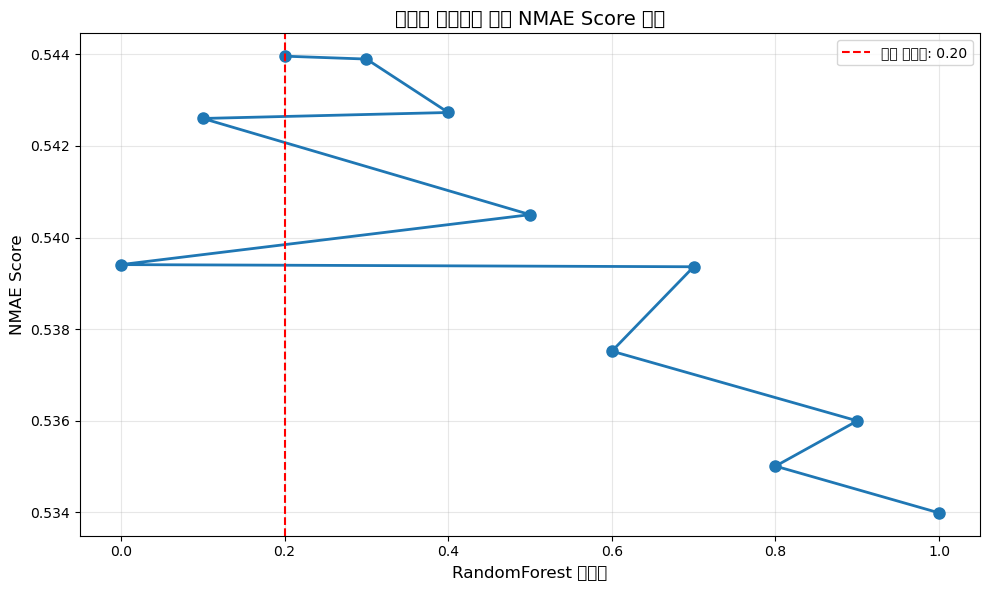


그래프가 표시되었습니다.


In [ ]:
# 가중치별 성능 그래프 (선택사항)
try:
    import matplotlib.pyplot as plt
    
    plt.figure(figsize=(10, 6))
    plt.plot(results_df['rf_weight'], results_df['NMAE_Score'], marker='o', linewidth=2, markersize=8)
    plt.xlabel('RandomForest 가중치', fontsize=12)
    plt.ylabel('NMAE Score', fontsize=12)
    plt.title('앙상블 가중치에 따른 NMAE Score 변화', fontsize=14)
    plt.grid(True, alpha=0.3)
    plt.axvline(x=best_result['rf_weight'], color='r', linestyle='--', label=f"최적 가중치: {best_result['rf_weight']:.2f}")
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    print("\n그래프가 표시되었습니다.")
except ImportError:
    print("matplotlib가 설치되어 있지 않아 그래프를 표시할 수 없습니다.")
except Exception as e:
    print(f"그래프 생성 중 오류 발생: {e}")
